# LIBRARIES

In [14]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_22732/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# DATASETS

## WINE DATASET

In [15]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (all except quality)
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop('quality')
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

# Create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# Data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality'] > 5] = 1

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_22732/984570066.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > 5] = 1


# SEPARATE THE DATA INTO BATCHES

In [16]:
# Convert from pandas dataframe to tensor
dataT  = torch.tensor(data=data[cols_2_zscore].values).float()
labels = torch.tensor(data=data['boolQuality'].values).float()
labels = labels[:, None] # Transform to matrix. We'll actually need the labels to be a "tensor"

In [17]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Now for the DL part

In [18]:
class ANN_wine(nn.Module):
  def __init__(self):
    super().__init__()

    # LAYERS
    # Input layer
    self.input = nn.Linear(11, 16)

    # Hidden layer(s). 'fc' = fully connected
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # Output layer
    self.output = nn.Linear(32, 1)
  
  # Forward pass
  def forward(self, x):
    x = F.relu(input=self.input(x))
    x = F.relu(input=self.fc1(x))
    x = F.relu(input=self.fc2(x))
    x = self.output(x)

    return x

# Train the model

In [19]:
def create_a_new_model():

  # Grab an instance of the model class
  ANN_model = ANN_wine()

  # Loss function
  loss_func = nn.BCEWithLogitsLoss()

  # Optimizer
  optimizer = torch.optim.SGD(params=ANN_model.parameters(), lr=0.01)

  return ANN_model, loss_func, optimizer

In [20]:
# Global parameter
num_epochs = 1000

def train_the_model(ANN_model, loss_func, optimizer):

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    ANN_model.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = ANN_model(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())
      
      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    ANN_model.eval()                # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      pred_labels = ANN_model(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

# Now for the experiment

In [21]:
# Range of batchsizes
batch_sizes = 2 ** np.arange(start=1, stop=10, step=2)

# Initialize output results matrices
accuracy_results_train = np.zeros(shape=(num_epochs, len(batch_sizes)))
accuracy_results_test  = np.zeros(shape=(num_epochs, len(batch_sizes)))
comp_time              = np.zeros(len(batch_sizes))

# Test data doesn't vary by training batch size
test_loader = DataLoader(dataset=test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# Loop over batch sizes
for batch_size_i in range(len(batch_sizes)):

    # Start the clock!
    start_time = time.process_time()

    # Create dataloader object
    train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_sizes[batch_size_i]), shuffle=True, drop_last=True)

    # Create and train a model
    ANN_wine_model, loss_func, optimizer = create_a_new_model()
    train_acc, test_acc, losses = train_the_model(ANN_model=ANN_wine_model, loss_func=loss_func, optimizer=optimizer)

    # Store data
    accuracy_results_train[:, batch_size_i] = train_acc
    accuracy_results_test[:, batch_size_i]  = test_acc

    # Check the timer
    comp_time[batch_size_i] = time.process_time() - start_time

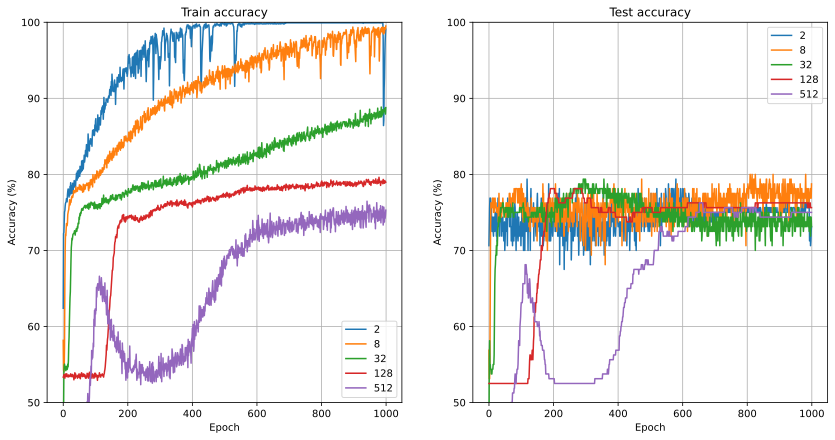

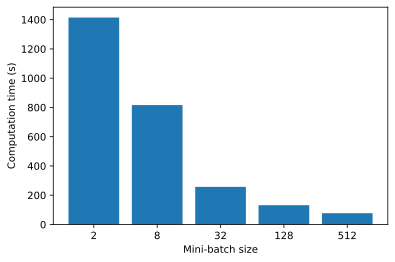

In [25]:
# Plot some results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
ax[0].plot(accuracy_results_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Test accuracy')

# Common features
for i in range(2):
  ax[i].legend(batch_sizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50, 100])
  ax[i].grid()

plt.show()

# Bar plot of computation time
plt.bar(range(len(comp_time)), comp_time, tick_label=batch_sizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

# Additional explorations

In [23]:
# 1) There is another regularization technique called "early stopping," which simply means to stop training the model
#    earlier than the number of epochs you specified. Early stopping is used when the test accuracy starts to decrease
#    with increased training. Do you think that early stopping would be beneficial here? How many epochs would you train?
# 
# 2) The training loop computes the losses, but those aren't plotted. Create an additional subplot to show the losses
#    in a similar fashion as the accuracy. Does that plot provide any additional insights into the effects of minibatch
#    size, beyond what we can already learn from the accuracy plots.
# 